In [1]:
from utils import *
from models import *
from loss import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

In [2]:
train_path = '../next_day_fires/next_day_wildfire_spread_train*'
val_path = '../next_day_fires/next_day_wildfire_spread_eval*'
test_path = '../next_day_fires/next_day_wildfire_spread_test*'
features = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']

# Load Data

## Training Data

In [3]:
train_dataset = get_dataset(
      train_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

train_inputs, train_labels = next(iter(train_dataset))

print(train_inputs.shape)
print(train_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


In [4]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

n_rows = 5
n_features = train_inputs.shape[3] 
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

In [5]:
# fig = plt.figure(figsize=(20,8))

# for i in range(n_rows):
#   for j in range(n_features + 1):
#     plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
#     if i == 0:
#       plt.title(titles[j], fontsize=15)
#     if j < n_features - 1:
#       plt.imshow(train_inputs[i, j, :, :], cmap='viridis')
#     if j == n_features - 1:
#       plt.imshow(train_inputs[i, -1, :, :], cmap=CMAP, norm=NORM)
#     if j == n_features:
#       plt.imshow(train_labels[i, 0, :, :], cmap=CMAP, norm=NORM) 
#     plt.axis('off')
# plt.tight_layout()

## Vlidation Data

In [6]:
val_dataset = get_dataset(
      val_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

val_inputs, val_labels = next(iter(val_dataset))

print(val_inputs.shape)
print(val_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


## Test Data

In [7]:
test_dataset = get_dataset(
      test_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_inputs, test_labels = next(iter(val_dataset))

print(test_inputs.shape)
print(test_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


In [8]:
# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=None, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=None, num_workers=0, pin_memory=True)

# Model Initialization

In [9]:
folder_path = './gen_models'
gen_input_channels = 12
disc_input_channels = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [10]:
#  Hyperparameters
kernel_size = 4 # DO NOT CHANGE
stride = 2 # DO NOT CHANGE
padding = 1 # DO NOT CHANGE
dropout = 0.5

gen_lr = 1e-4
disc_lr = 1e-4

alpha = 1
lambd = 2
pos_weight = 30
bce_weight = 0.5

num_epochs = 1000
patience = 100


### Model Initialization

In [11]:
generator = Generator(gen_input_channels, kernel_size, stride, padding, dropout)
discriminator = Discriminator(disc_input_channels, kernel_size, stride, padding)

generator.apply(init_weights)
discriminator.apply(init_weights)

generator.to(device)
discriminator.to(device)

Discriminator(
  (e1): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lr1): LeakyReLU(negative_slope=0.2)
  (e2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr2): LeakyReLU(negative_slope=0.2)
  (e3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr3): LeakyReLU(negative_slope=0.2)
  (output): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

# Model Training

In [12]:
gen_best_val_loss = float('inf')
epochs_no_improve = 0
gen_best_model_state = None
bgen_est_model_filename = None

# Optimizers and loss functions
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))
gen_criterion = GenLoss(alpha=alpha, lambd=lambd, pos_weight=torch.tensor([pos_weight]).to(device), bce_weight=bce_weight)
disc_criterion = DiscLoss()
torch.autograd.set_detect_anomaly(True)
# Train over the entire dataset every epoch

generator.load_state_dict(torch.load("./gen_models/best_model_0.8274214518697638_20250427_160049.pth", map_location=device, weights_only=True))

for epoch in range(num_epochs):
    if epoch == 50:
        gen_best_val_loss = float('inf')
        gen_criterion.alpha = 0.5
        for p in discriminator.parameters():
            p.requires_grad = True
    elif epoch == 0:
        gen_criterion.alpha = 0
        for p in discriminator.parameters():
            p.requires_grad = False
            
    generator.train()
    discriminator.train()

    gen_total_loss = 0
    disc_total_loss = 0

    # Train in batches 
    for batch in train_loader:
        images, target = batch
        images = images.to(device)
        target = target.to(device)
        # Update Discriminator
        disc_optimizer.zero_grad()

        # Generate fake images
        with torch.no_grad():
            generated = generator(images)
        generated_detached = generated.detach()

        # Discriminator loss
        real_pred = discriminator(target, images)
        fake_pred = discriminator(generated_detached, images)
        disc_loss = disc_criterion(real_pred, fake_pred)

        if epoch > 49:
            disc_loss.backward()
            disc_optimizer.step()

        # Update generator
        gen_optimizer.zero_grad()

        # Re-forward generator
        generated = generator(images)
        gen_pred = discriminator(generated, images)
        gen_loss = gen_criterion(
            gen_logits=generated, 
            disc_pred=gen_pred, 
            target_mask=target
        )
        #gen_loss = gen_criterion(gen_pred, generated, target)

        gen_loss.backward()
        gen_optimizer.step()

        # Add loss to totals
        gen_total_loss = gen_total_loss + gen_loss.item()
        disc_total_loss = disc_total_loss + disc_loss.item()

    # Average the loss over all batches
    gen_avg_loss = gen_total_loss / len(train_loader)
    disc_avg_loss = disc_total_loss / len(train_loader)


    # Now, validate the model
    generator.eval()
    discriminator.eval()
    gen_val_loss = 0
    disc_val_loss = 0

    # Gradients are not used as validation is used to find the best model without further optimization
    with torch.no_grad():
        # Validate in batches
        for batch in val_loader:
            images, target = batch
            images = images.to(device)
            target = target.to(device)
            
            # Make predictions on the validation images
            generated = generator(images)
            gen_pred = discriminator(generated, images)
            real_pred = discriminator(target, images)

            # Calculate the loss
            #gen_loss = gen_criterion(gen_pred, generated, target)
            gen_loss = gen_criterion(
                gen_logits=generated, 
                disc_pred=gen_pred, 
                target_mask=target
            )
            disc_loss = disc_criterion(real_pred, gen_pred)
            gen_val_loss = gen_val_loss + gen_loss.item()
            disc_val_loss = disc_val_loss + disc_loss.item()


    
    # Average the validation loss over all batches
    gen_avg_val_loss = gen_val_loss / len(val_loader)
    disc_avg_val_loss = disc_val_loss / len(val_loader)
    
    
    print(f"Epoch {epoch + 1}/{num_epochs}\
          \n   - Generator Train Loss: {gen_avg_loss:.4f} - Generator Validation Loss: {gen_avg_val_loss:.4f}\
          \n   - Discriminator Train Loss: {disc_avg_loss:.4f} - Discriminator Validation Loss: {disc_avg_val_loss:.4f}")

    # Best model saving & early stopping
    if gen_avg_val_loss < gen_best_val_loss:
        gen_best_val_loss = gen_avg_val_loss
        epochs_no_improve = 0
        gen_best_model_state = generator.state_dict() 
        gen_best_model_filename = f"{folder_path}/best_model_{str(gen_best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

Epoch 1/1000          
   - Generator Train Loss: 2.6854 - Generator Validation Loss: 2.6421          
   - Discriminator Train Loss: 1.5029 - Discriminator Validation Loss: 1.4492
Validation loss improved. Best model updated.
Epoch 2/1000          
   - Generator Train Loss: 2.6858 - Generator Validation Loss: 2.6691          
   - Discriminator Train Loss: 1.5048 - Discriminator Validation Loss: 1.4710
No improvement for 1 epoch(s).
Epoch 3/1000          
   - Generator Train Loss: 2.6787 - Generator Validation Loss: 2.6245          
   - Discriminator Train Loss: 1.5039 - Discriminator Validation Loss: 1.4589
Validation loss improved. Best model updated.
Epoch 4/1000          
   - Generator Train Loss: 2.6771 - Generator Validation Loss: 2.6469          
   - Discriminator Train Loss: 1.5034 - Discriminator Validation Loss: 1.4672
No improvement for 1 epoch(s).
Epoch 5/1000          
   - Generator Train Loss: 2.6832 - Generator Validation Loss: 2.6992          
   - Discriminator 

In [15]:
# save the best model
os.makedirs('./gen_models/models', exist_ok=True)
if gen_best_model_state is not None:
    torch.save(gen_best_model_state, gen_best_model_filename)
    print(f"Best model saved to {gen_best_model_filename}")

Best model saved to ./gen_models/best_model_0.8960700082151514_20250428_015556.pth


# Model Testing

In [16]:
generator.load_state_dict(torch.load(gen_best_model_filename, map_location=device, weights_only=True))
generator.eval()

# Arrays to store all predictions and all ground truth masks
pred_mask_all, target_all = [], []

with torch.no_grad():
    for batch in test_loader:
        images, target = batch
        images = images.to(device)
        target = target.to(device)

        # Make test predictions
        pred_mask = generator(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        target_all.append(target.cpu().numpy())

    # Concatenate all batches into a single array for performance                        
    preds = np.concatenate(pred_mask_all, axis=0)   
    trues = np.concatenate(target_all, axis=0)        

    # Squeeze from 4 dimensions into 3 since we use only one channel
    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    # Binarize predictions
    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    # Calculate TP, FP, FN for evaluation metrics
    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    # Calculate evaluation metrics
    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")


 **Test Results:**
Dice Coefficient: 0.0788
IoU: 0.0410
Recall: 0.4675


In [17]:
img, lab = next(iter(test_loader))
pred = generator(img.to(device))


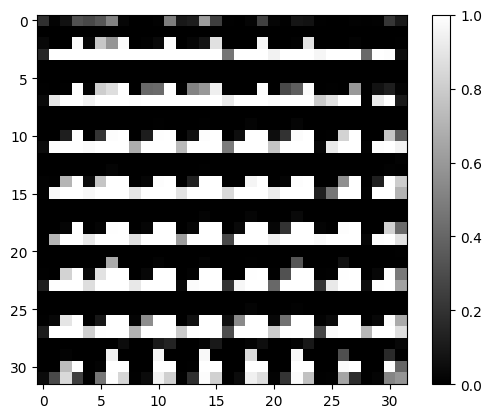

In [23]:
tensor_np = pred[1][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

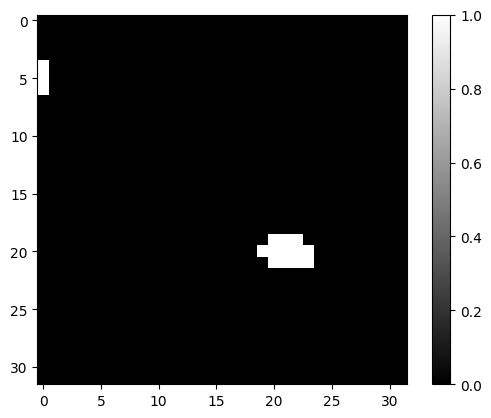

In [22]:
tensor_np = lab[1][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()